In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import scipy.linalg as linalg



class OptionsPricing(object):
    def __init__(self, S0, K, r, T, sigma, is_call=True):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.is_call = is_call

In [13]:



class FiniteDifferences(OptionsPricing):
    """ Shared attributes and functions of FD """

    def __init__(self, S0, K, r, T, sigma, Smax, M, N, is_call=True):
        super(FiniteDifferences, self).__init__(S0, K, r, T, sigma, is_call)
        self.Smax = Smax
        self.M, self.N = int(M), int(N)  # Ensure M&N are integers

        self.dS = Smax / float(self.M)
        self.dt = T / float(self.N)
        self.iValues = np.arange(1, self.M)
        self.jValues = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1)) # grid is M+1 by N+1
        self.SValues = np.linspace(0, Smax, self.M+1)

    def _setup_boundary_conditions_(self):
        pass

    def _setup_coefficients_(self):
        pass

    def _traverse_grid_(self):
        """  Iterate the grid backwards in time """
        pass

    def _interpolate_(self):
        """
        Use piecewise linear interpolation on the initial
        grid column to get the closest price at S0.
        """
        return np.interp(self.S0,
                         self.SValues,
                         self.grid[:, 0])

    def price(self):
        self._setup_coefficients_()
        self._setup_boundary_conditions_()
        self._traverse_grid_()
        return self._interpolate_()

In [14]:


class ExplicitEu(FiniteDifferences):
    
    def _setup_coefficients_(self):
        self.alpha = 0.5*self.dt * (self.sigma**2 * self.iValues**2 - self.r * self.iValues)
        self.beta  = - self.dt * (self.sigma**2 * self.iValues**2 + self.r)
        self.gamma = 0.5*self.dt * (self.sigma**2 * self.iValues**2 + self.r * self.iValues)
        self.coeffs = np.diag(self.alpha[1:], -1) + \
                      np.diag(1 + self.beta) + \
                      np.diag(self.gamma[:-1], 1)
        
    def _setup_boundary_conditions_(self):
        # terminal condition
        if self.is_call:
            self.grid[:, -1] = np.maximum(self.SValues - self.K, 0)
        else:
            self.grid[:, -1] = np.maximum(self.K - self.SValues, 0)
            
        # side boundary conditions
        self.coeffs[0,   0] += 2*self.alpha[0]
        self.coeffs[0,   1] -= self.alpha[0]
        self.coeffs[-1, -1] += 2*self.gamma[-1]
        self.coeffs[-1, -2] -= self.gamma[-1]
        
    def _traverse_grid_(self):
        for j in reversed(self.jValues):
            self.grid[1:-1, j] = np.dot(self.coeffs, self.grid[1:-1, j+1])
            self.grid[0, j] = 2 * self.grid[1, j] - self.grid[2, j]
            self.grid[-1, j] = 2 * self.grid[-2, j] - self.grid[-3, j]

    

In [15]:

class BSClosedForm(OptionsPricing):
    # call or put
    def price(self):
        d1 = ((self.r + 0.5 * self.sigma**2) * self.T - np.log(self.K / self.S0)) / (self.sigma * np.sqrt(self.T))
        d2 = ((self.r - 0.5 * self.sigma**2) * self.T - np.log(self.K / self.S0)) / (self.sigma * np.sqrt(self.T))
        if self.is_call:
            p = self.S0 * norm.cdf(d1) - np.exp(-self.r * self.T) * self.K * norm.cdf(d2) 
        else:               
            p = np.exp(-self.r * self.T) * self.K * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        return p

In [16]:

class ImplicitEu(ExplicitEu):
    
    def _setup_coefficients_(self):
        self.alpha =  0.5*self.dt * (self.r * self.iValues - self.sigma**2 * self.iValues**2)
        self.beta  =  self.dt * (self.r + self.sigma**2 * self.iValues**2)
        self.gamma = -0.5*self.dt * (self.r * self.iValues + self.sigma**2 * self.iValues**2)
        self.coeffs = np.diag(self.alpha[1:], -1) + \
                      np.diag(1 + self.beta) + \
                      np.diag(self.gamma[:-1], 1)
    
    def _traverse_grid_(self):           
        P, L, U = linalg.lu(self.coeffs)
        for j in reversed(self.jValues):
            Ux = linalg.solve(L, self.grid[1:-1, j+1])
            self.grid[1:-1, j] = linalg.solve(U, Ux)
            self.grid[0, j] = 2 * self.grid[1, j] - self.grid[2, j]
            self.grid[-1, j] = 2 * self.grid[-2, j] - self.grid[-3, j]



4.072882218686989
4.071594116199564


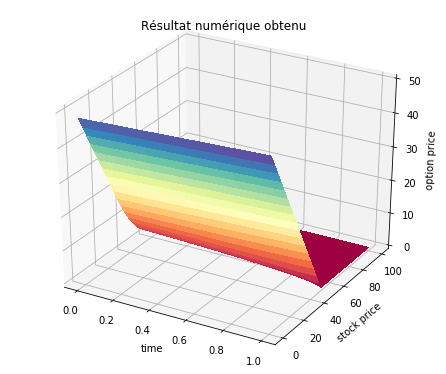

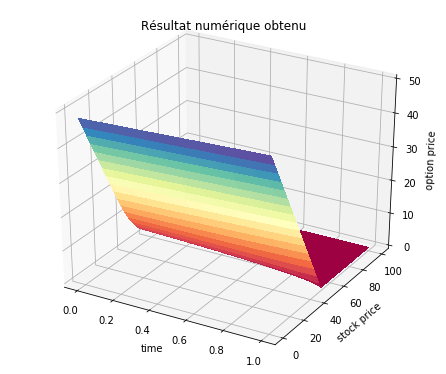

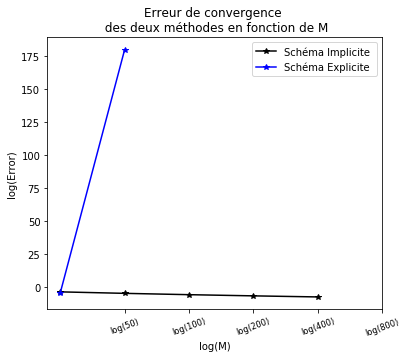

In [17]:
#TEST TEST TEST
# set up parameters
S0 = 50
K = 50
r = 0.1
T = 5/12
sigma = 0.4
Smax = 100
M = 100  # S
N = 1000 # t
is_call = False

# pricing test
option = ExplicitEu(S0, K, r, T, sigma, Smax, M, N, is_call)
print(option.price())


option = ImplicitEu(S0, K, r, T, sigma, Smax, M, N, is_call)
print(option.price())
#   
# convergence error 
def convergeError(method, S0, K, r, T, sigma, Smax, m, n, is_call):
    p = np.array([])
    for M, N in zip(m, n):
        option = method(S0, K, r, T, sigma, Smax, M, N, is_call)
        p = np.append(p, option.price())
    option = BSClosedForm(S0, K, r, T, sigma, is_call)
    error = np.abs(p-option.price())
    return error, p, option.price()

m = np.array([50, 100, 200, 400, 800])
n = np.array([100, 200, 400, 800, 1600])
errorImp, impPrice, anaPrice = convergeError(ImplicitEu, S0, K, r, T, sigma, Smax, m, n, is_call)
errorExplicitEu, ExplicitEuPrice, anaPrice = convergeError(ExplicitEu, S0, K, r, T, sigma, Smax, m, n, is_call)

#   #==============================================================================
# plotting
#==============================================================================
# price surface
def priceSurface(method, S0, K, r, T, sigma, Smax, M, N, is_call):
    fig = plt.figure(figsize=(6,5))
    ax = Axes3D(fig)
    t, S = np.meshgrid(np.linspace(0, 1, N+1), np.linspace(0, Smax, M+1))
    option = method(S0, K, r, T, sigma, Smax, M, N, is_call)
    option.price()
    ax.plot_surface(t, S, option.grid, cmap='Spectral', linewidth=0, antialiased=False)
    ax.set_xlabel('time')
    ax.set_ylabel('stock price')
    ax.set_zlabel('option price')
    ax.set_title('Résultat numérique obtenu')
    plt.show()
N = 1000
priceSurface(ExplicitEu, S0, K, r, T, sigma, Smax, M, N, is_call)

priceSurface(ImplicitEu, S0, K, r, T, sigma, Smax, M, N, is_call)

# convergence
fig = plt.figure(figsize=(6,5)) 
ax = fig.gca()
ax.plot(np.log(m), np.log(errorImp), '*-', c='black')
ax.plot(np.log(m), np.log(errorExplicitEu), '*-', c='blue')
ticks = ax.set_xticks(np.log(n))
labels = ax.set_xticklabels(['log(50)','log(100)', 'log(200)', 
                                'log(400)', 'log(800)'], rotation=20, fontsize='small')
ax.set_xlabel('log(M)')
ax.set_ylabel('log(Error)')
ax.set_title('Erreur de convergence \n des deux méthodes en fonction de M')
plt.legend(['Schéma Implicite ', 'Schéma Explicite'])
plt.show()

#   



